In [2]:
# 1. Import libraries
import numpy as np
import pandas as pd
import matplotlib.pylab as plt

from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV
from sklearn.metrics import mean_squared_error

# For the neural network
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# Optional: for scaling
from sklearn.preprocessing import StandardScaler


In [3]:
# 2. Load the dataset (Hitters)

url = 'https://drive.google.com/uc?export=download&id=11NGvo9A2eyHQe_t3u94zN_i0_C1op75U'
df_hitters = pd.read_csv(url)

# Quick look at the dataset
df_hitters.head()


,Unnamed: 0,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,...,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
0,-Andy Allanson,293,66,1,30,29,14,1,293,66,...,30,29,14,A,E,446,33,20,NaN,A
1,-Alan Ashby,315,81,7,24,38,39,14,3449,835,...,321,414,375,N,W,632,43,10,475.0,N
2,-Alvin Davis,479,130,18,66,72,76,3,1624,457,...,224,266,263,A,W,880,82,14,480.0,A
3,-Andre Dawson,496,141,20,65,78,37,11,5628,1575,...,828,838,354,N,E,200,11,3,500.0,N
4,-Andres Galarraga,321,87,10,39,42,30,2,396,101,...,48,46,33,N,E,805,40,4,91.5,N


In [4]:
# 3. Check for missing values and clean the data
# The Salary column often has missing values. Let's remove those rows for simplicity.

print("Number of rows before dropping missing values:", df_hitters.shape[0])
df_hitters.dropna(subset=["Salary"], inplace=True)
print("Number of rows after dropping missing values:", df_hitters.shape[0])

# Convert Salary to numeric in case it's read as a string
df_hitters["Salary"] = pd.to_numeric(df_hitters["Salary"])


Number of rows before dropping missing values: 322
Number of rows after dropping missing values: 263


In [5]:
# 4. Convert categorical columns to dummy variables

# We'll look at the types of each column:
df_hitters.info()

# Common categorical features in Hitters: League, Division, and NewLeague
# We can use pandas.get_dummies to handle them

df_hitters = pd.get_dummies(df_hitters, columns=["League", "Division", "NewLeague"], drop_first=True)

# Now df_hitters has no more object-type columns
df_hitters.info()


<class 'pandas.core.frame.DataFrame'>
Index: 263 entries, 1 to 321
Data columns (total 21 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  263 non-null    object 
 1   AtBat       263 non-null    int64  
 2   Hits        263 non-null    int64  
 3   HmRun       263 non-null    int64  
 4   Runs        263 non-null    int64  
 5   RBI         263 non-null    int64  
 6   Walks       263 non-null    int64  
 7   Years       263 non-null    int64  
 8   CAtBat      263 non-null    int64  
 9   CHits       263 non-null    int64  
 10  CHmRun      263 non-null    int64  
 11  CRuns       263 non-null    int64  
 12  CRBI        263 non-null    int64  
 13  CWalks      263 non-null    int64  
 14  League      263 non-null    object 
 15  Division    263 non-null    object 
 16  PutOuts     263 non-null    int64  
 17  Assists     263 non-null    int64  
 18  Errors      263 non-null    int64  
 19  Salary      263 non-null    float6

In [6]:
# 5. Define features (X) and target (y)

# "Salary" is the typical target variable in the Hitters dataset
y = df_hitters["Salary"].values

# We drop Salary and Player name (if present).
# Some versions of the dataset contain "Player" or "Unnamed: 0", so remove them if they exist.
drop_cols = ["Salary", "Player", "Unnamed: 0"]  # not all might exist, so let's filter
drop_cols = [col for col in drop_cols if col in df_hitters.columns]
X = df_hitters.drop(columns=drop_cols)

X.head()


,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,PutOuts,Assists,Errors,League_N,Division_W,NewLeague_N
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,632,43,10,True,True,True
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,880,82,14,False,True,False
3,496,141,20,65,78,37,11,5628,1575,225,828,838,354,200,11,3,True,False,True
4,321,87,10,39,42,30,2,396,101,12,48,46,33,805,40,4,True,False,True
5,594,169,4,74,51,35,11,4408,1133,19,501,336,194,282,421,25,False,True,False


In [7]:
# 6. Split into training and test sets

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=42)

print("Training set shape:", X_train.shape)
print("Test set shape:", X_test.shape)


Training set shape: (210, 19)
Test set shape: (53, 19)


In [8]:
# 7. Scale the features (optional but often helps with neural networks)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)


In [9]:
# 8. Build a neural network model using Keras Sequential API

model = Sequential()

# Add layers. We'll create a simple 2-hidden-layer network:
model.add(Dense(32, activation='relu', input_shape=(X_train_scaled.shape[1],)))
model.add(Dropout(0.2))  # Dropout to reduce overfitting
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1))  # Single output neuron for a regression problem

# Compile the model
model.compile(optimizer='adam', loss='mse')

# Print the model summary
model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 32)                  │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,185 (4.63 KB)

 Trainable params: 1,185 (4.63 KB)

 Non-trainable params: 0 (0.00 B)

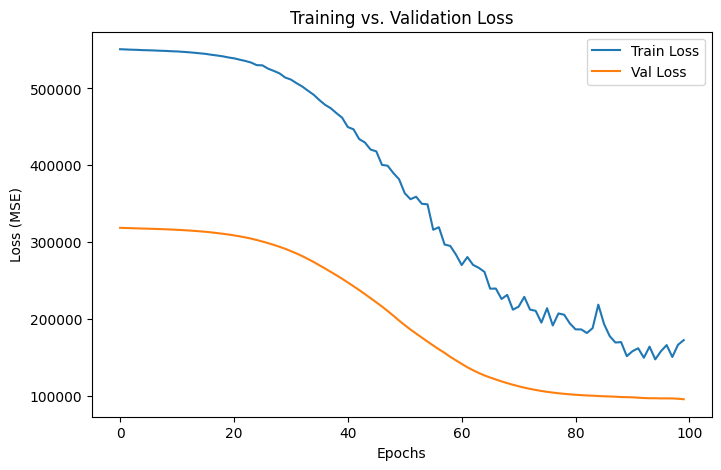

In [10]:
# 9. Train the model

history = model.fit(X_train_scaled, y_train,
                    validation_split=0.2,  # from the training set
                    epochs=100,
                    batch_size=32,
                    verbose=0)  # verbose=0 to suppress per-epoch output

# We can plot the training and validation loss to see if we're overfitting
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Training vs. Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.show()


In [11]:
# 10. Evaluate model performance on the test set

y_pred = model.predict(X_test_scaled).flatten()  # Flatten to 1D
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print("Test MSE:", mse)
print("Test RMSE:", rmse)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Test MSE: 134985.51028462817
Test RMSE: 367.4037428832594
